In [130]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

data = pd.read_csv('gmm_1d.csv')

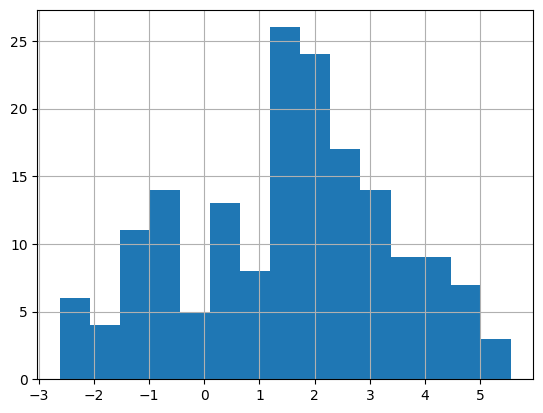

In [2]:
# data.groupby('z_i')['y_i'].hist(bins=15)
data['y_i'].hist(bins=15)
plt.show()

$$ y_i \sim p_y\left(y_i\right) $$
where
\begin{align}
    p_y\left(y_i\right) & = \sum_{k=0}^K p\left(y_i , z_i = k \right) \\ 
    & = \sum_{k=0}^K p\left(y_i \, \middle| \, z_i = k\right)p\left(z_i = k \right) \\ 
    & = \sum_{k=0}^K p\left(y_i \, \middle| \, z_i = k\right)p\left(z_i = k \right) \\ 
    & = \sum_{k=0}^K p\left(y_i \, \middle| \, z_i = k\right)\pi_{k} \\ 
    & = \sum_{k=0}^K q\left(y_i \, \middle| \, \mu_k, \sigma^2_k\right)\pi_{k} \\ 
\end{align}

In [160]:
def norm_pdf_v(y, v_mu, v_log_sigma2):
    """Return the probabilities of observing y under each univariate normal distribution specified by the means
    in mu and the scales in sigma."""
    component_probs = []
    for component in range(len(v_mu)):
        component_dist = torch.distributions.Normal(loc=v_mu[component], scale=v_log_sigma2[component].exp())
        component_probs.append(component_dist.log_prob(y).exp())

    return torch.tensor(component_probs, dtype=torch.float)


def likelihood_obs(y, mu, log_sigma2, mw):
    """Compute the likelihood for a single observation."""
    npdf = norm_pdf_v(y, v_mu=mu, v_log_sigma2=log_sigma2)
    return torch.dot(npdf, mw)

def log_likelihood_batch(Y, mu, log_sigma2, mw):
    ll = torch.tensor(0.0)
    for y_i in Y:
        ll.add_(
            likelihood_obs(y_i, mu=mu, log_sigma2=log_sigma2, mw=mw).clamp(1e-7).log()
        )
    return ll.sum()

In [161]:
data_t = torch.tensor(data['y_i']).unsqueeze(-1)

K = torch.tensor(data['z_i'].nunique())

# Mixture weights (prior over mixture components)
log_mixing_weights_k = torch.tensor(np.log(K * [1/K]), requires_grad=True, dtype=torch.float)
mu_k = torch.tensor([-0.7, 0.9, 4.0, 2.0], requires_grad=True)
log_sigma2_k = torch.tensor([0.0, 0.0, 0.0, 0.0], requires_grad=True)

n_data = data_t.shape[0]
step_scale = 0.02
step_scale_pi = 0.01

num_epochs = 200
like_traj = torch.zeros(num_epochs, requires_grad=False)
log_mixing_weights_traj = torch.zeros((num_epochs, K), requires_grad=False)
mus = torch.zeros((num_epochs, K), requires_grad=False)
log_sigma2s = torch.zeros((num_epochs, K), requires_grad=False)


for epoch in range(num_epochs):
    for i in range(n_data):

        mixing_weights = torch.softmax(log_mixing_weights_k, dim=0)
        likelihood = likelihood_obs(data_t[i], mu=mu_k, log_sigma2=log_sigma2_k, mw=mixing_weights)

        grads = torch.autograd.grad([likelihood], (mu_k, log_sigma2_k, log_mixing_weights_k))

        with torch.no_grad():
            # perform gradient ascent
            mu_k += step_scale * grads[0]
            log_sigma2_k += step_scale * grads[1]
            log_mixing_weights_k += step_scale_pi * grads[2]


    with torch.no_grad():
        # calculate likelihood of whole dataset
        like_traj[epoch] = log_likelihood_batch(data_t, mu=mu_k, log_sigma2=log_sigma2_k, mw=mixing_weights)
        
        mus[epoch, :] = mu_k
        log_sigma2s[epoch, :] = log_sigma2_k
        log_mixing_weights_traj[epoch, :] = log_mixing_weights_k

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

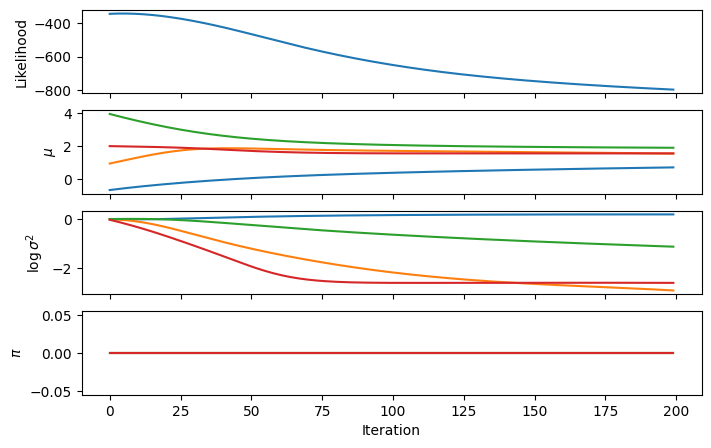

In [146]:
fig, ax = plt.subplots(nrows=4, figsize=(8, 5), sharex=True)

ax[0].plot(like_traj)

for k in range(4):
    ax[1].plot(mus[:,k], label=fr'$\mu_{k}$')
    ax[2].plot(log_sigma2s[:,k], label=fr'$\log\sigma_^2{k}$')
    ax[3].plot(pis[:,k])
# ax[1].legend()
# ax[2].legend()
ax[1].set_ylabel(r"$\mu$")
ax[2].set_ylabel(r"$\log \sigma^2$")
ax[3].set_ylabel(r"$\pi$")

ax[0].set_ylabel('Likelihood')
ax[3].set_xlabel('Iteration')
plt.show()

## Attempt 2
 

In [5]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

data = pd.read_csv('gmm_1d.csv')

In [175]:
K = torch.tensor(data['z_i'].nunique())

# Mixture weights (prior over mixture components)
pi_k = torch.distributions.Dirichlet(torch.tensor([1.0]*K)).sample()
pi_k.requires_grad = True

# Mixture means
mu_k = torch.distributions.Normal(loc=data['y_i'].mean(), scale=data['y_i'].std()).sample([K])
mu_k.requires_grad = True
# mu_k = torch.tensor([-0.7, 0.9, 4.0, 2.0], requires_grad=True)

# Mixture scales
# sigma_k = torch.distributions.Uniform(low=1, high=3.0).sample([K])
# sigma_k.requires_grad = True
# sigma_k = torch.tensor([0.75, .75, 0.75, 0.75], requires_grad=True)
sigma_k = torch.tensor([0.75, 0.75, 0.75, 0.75], requires_grad=False)

n_data = data.shape[0]


In [176]:
l2p = torch.tensor(2 * torch.pi).log()

def log_normal_pdf(x, mu, sigma):
    """Return the log-likelihood of observing x under N(mu, sigma)."""
    return -(l2p + torch.log(torch.pow(sigma,2)) + torch.pow(torch.div(x-mu, sigma), 2) ) / 2


data_t = torch.tensor(data['y_i'].values, dtype=torch.float)
def log_likelihood(mu_k, sigma_k, pi_k):
    ll_accum = torch.tensor(0.0)
    for i in range(n_data):
        for k in range(K):
            ll_accum += (pi_k[k] * log_normal_pdf(data_t[i], mu_k[k], sigma_k[k]).exp()).log()
    return ll_accum

In [177]:


lls = []
for epoch in range(10):
    mu_k_init = mu_k.clone().detach().requires_grad_(True)
    pi_k_init = pi_k.clone().detach().requires_grad_(True)

    # test computation
    ll = log_likelihood(mu_k_init, sigma_k, pi_k_init)
    ll.backward()

    with torch.no_grad():
        mu_k = mu_k_init - 0.001 * mu_k_init.grad
        pi_k = pi_k_init - 0.001 * pi_k_init.grad

        lls.append(ll.item())



